In [2]:
using JuMP, Gurobi
using CSV, LinearAlgebra, DataFrames
using Plots

In [3]:
#load social and ecological data and orgnize 
FL = repeat([Float64], inner=15)
dtype = append!([String], FL);

regional_EF = CSV.File("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/data/social/new_EF_SC1.csv",header=1,delim=",", types=dtype) |> DataFrame    
capacity = CSV.File("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/data/social/capacity2.csv",header=1,delim=",", types=dtype) |> DataFrame    
distance = CSV.File("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/data/social/distance.csv",header=1,delim=",") |> DataFrame 
LCA_model = CSV.File("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/data/social/LCA_model2.csv",header=1,delim=",") |> DataFrame 
D_Dsoc = CSV.File("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/data/social/D_Dsoc1.csv",header=1,delim=",") |> DataFrame
GDP = CSV.File("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/data/social/GDP.csv",header=1,delim=",") |> DataFrame;
emi_sink = CSV.File("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/data/SC_regional/emission_sink1.csv",header=1,delim=",") |> DataFrame;


### Ecological

In [4]:
cell_demand = 0.001*164.98*(1.3*1e6)*2           # annual demand of Li battery for tesla (1.369M EV/yr, ~2 NMC111 pack/EV, 226 kg/pack (35kwh/pack), 80~100 kWh per EV)

global_sink = 1.099e10                        # global pub (ocean) CO2 sequestration (ton/yr)
global_sink_tot = 2.236e10                  # global total (ocean+land) CO2 sequestration (ton/yr)
global_emi = 3.53e10                          # global CO2 emission (ton/yr)
es_ratio = global_sink/global_emi
es_ratio_tot = global_sink_tot/global_emi
emission_c = emi_sink[!, "emission"]          # national CO2 emission (ton/yr)
sink_c = emi_sink[!, "sink ton/yr"]           # national CO2 sink (ton/yr)

D = D_Dsoc[!, "D"]          # national CO2 emission (ton/yr)
Dsoc = D_Dsoc[!, "Dsoc ton/yr"]           # national CO2 sink (ton/yr)

EF_trans = 1.005/10000                        # ton CO2/km*ton (The average freight truck in the U.S. emits 161.8 grams of CO2 per ton-mile)
process = LCA_model[!,"process"]
countries = capacity[!,"country"]
ncty = size(countries,1)                          # No. of countries
nproc = size(process,1);                          # No. of processes 

mkt_loc = findfirst(isequal("United States"), countries)
mkt_proc = findfirst(isequal("battery"), process)

# seperate model
cathode = 1:4
cell = 5:10
noncell = [12,13]
battery = [11,14]
scaler = LCA_model[!,"scaler"]
price = LCA_model[!,"price (usd/ton product)"]
vGDP = GDP[!,"GDP usd"];

In [5]:
up_cath = scaler[1:4] * scaler[5] * scaler[11]
up_cell = scaler[5:10] * scaler[11]
cell_sef = scaler[11]
up_noncell = scaler[12:13] * scaler[14]
noncell_sef = scaler[14]
battery_sef = scaler[15];

In [6]:
input_amount = []
input_amount = vcat(up_cath, up_cell, cell_sef, up_noncell, noncell_sef, battery_sef) .* cell_demand
input_amount

MktV = price .* input_amount ;  # ton

---

In [7]:
model = Model(Gurobi.Optimizer);

Academic license - for non-commercial use only - expires 2023-11-27


In [8]:
#variables 
@variable(model, x[1:ncty, 1:nproc] >= 0)            # x[i,k] production amount of product k at location i
@variable(model, y[1:ncty, 1:ncty, 1:nproc] >= 0)   # y[i,j,k] ship product k from i to j 
@variable(model, delta[1:ncty], binary=true);

In [9]:
# capacity constraint: x[i,k] <= capacity[i][k]
for k in 1:nproc
    for i in 1:ncty
        @constraint(model, x[i,k] <= capacity[!, 2:end][i,k])
    end
end


# node output flow constraint
for k in 1:nproc
    for i in 1:ncty
        @constraint(model, sum(y[i,j,k] for j in 1:ncty) == x[i,k])
    end
end


# node output flow to market y[i,38, 15]
for i in 1:ncty
    for j in [e for e in 1:ncty if e != mkt_loc]
        @constraint(model, y[i,j,mkt_proc] == 0)
    end
end


for k in 1:nproc-1
    @constraint(model, sum(x[i,k] for i in 1:ncty) == input_amount[k])
end


# final demand constraint
@constraint(model, sum(y[i,mkt_loc,mkt_proc] for i in 1:ncty) == cell_demand);

In [10]:
# cathode LCA constraints (index=5)
for k in cathode
    for j in 1:ncty
        @constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,5] * scaler[k])
    end
end


# cell LCA constraints (index=11)
for k in cell
    for j in 1:ncty
        @constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,11] * scaler[k])
    end
end


# non cell LCA constraints (index=14)
for k in noncell
    for j in 1:ncty
        @constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,14] * scaler[k])
    end
end


# battery LCA constraints (index=15)
for k in battery
    for j in 1:ncty
        @constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,15] * scaler[k])
    end
end

In [11]:
# 1. production emission (TES)
val_x = zeros(ncty, nproc)

for k in 1:nproc
    for i in 1:ncty
        val_x[i,k] = regional_EF[i, k+1] * (1 - sink_c[i]/emission_c[i] - es_ratio)
    end
end

proc_emi = sum(x .* val_x);

In [12]:
# 2. transpotration emission (TES, w/ supply)
trans_emi = 0

for i in 1:ncty
    for j in 1:ncty
        amount = sum(y[i,j,k] for k in 1:nproc)
        arc_emi = amount * distance[!, 2:end][i,j] * EF_trans
        arc_seq = arc_emi * (sink_c[j]/emission_c[j] + es_ratio)
        arc_net = arc_emi - arc_seq
        trans_emi += arc_net
    end
end

In [13]:
@objective(model, Min, proc_emi+trans_emi);

In [14]:
JuMP.optimize!(model)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 2205 rows, 13980 columns and 28740 nonzeros
Model fingerprint: 0xfe002d69
Variable types: 13950 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [7e-03, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2089 rows and 13538 columns
Presolve time: 0.02s
Presolved: 116 rows, 442 columns, 923 nonzeros
Variable types: 442 continuous, 0 integer (0 binary)

Root relaxation: objective -7.822274e+06, 14 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    -7822273.529 -7822273.5  

In [15]:
optx = copy(JuMP.value.(x))
opty = copy(JuMP.value.(y));

In [16]:
eco_opt = optx;

In [17]:
eco_opt_y = opty;

### Social

In [18]:
model1 = Model(Gurobi.Optimizer);

Academic license - for non-commercial use only - expires 2023-11-27


In [19]:
#variables 
@variable(model1, x[1:ncty, 1:nproc] >= 0)            # x[i,k] production amount of product k at location i
@variable(model1, y[1:ncty, 1:ncty, 1:nproc] >= 0)   # y[i,j,k] ship product k from i to j 
@variable(model1, delta[1:ncty], binary=true);

In [20]:
# capacity constraint: x[i,k] <= capacity[i][k]
for k in 1:nproc
    for i in 1:ncty
        @constraint(model1, x[i,k] <= capacity[!, 2:end][i,k])
    end
end

In [21]:
# node output flow constraint
for k in 1:nproc
    for i in 1:ncty
        @constraint(model1, sum(y[i,j,k] for j in 1:ncty) == x[i,k])
    end
end

In [22]:
# node output flow to market y[i,38, 15]
for i in 1:ncty
    for j in [e for e in 1:ncty if e != mkt_loc]
        @constraint(model1, y[i,j,mkt_proc] == 0)
    end
end

for k in 1:nproc-1
    @constraint(model1, sum(x[i,k] for i in 1:ncty) == input_amount[k])
end

In [23]:
# final demand constraint
@constraint(model1, sum(y[i,mkt_loc,mkt_proc] for i in 1:ncty) == cell_demand);

In [24]:
# cathode LCA constraints (index=5)
for k in cathode
    for j in 1:ncty
        @constraint(model1, sum(y[i,j,k] for i in 1:ncty) == x[j,5] * scaler[k])
    end
end


# cell LCA constraints (index=11)
for k in cell
    for j in 1:ncty
        @constraint(model1, sum(y[i,j,k] for i in 1:ncty) == x[j,11] * scaler[k])
    end
end


# non cell LCA constraints (index=14)
for k in noncell
    for j in 1:ncty
        @constraint(model1, sum(y[i,j,k] for i in 1:ncty) == x[j,14] * scaler[k])
    end
end


# battery LCA constraints (index=15)
for k in battery
    for j in 1:ncty
        @constraint(model1, sum(y[i,j,k] for i in 1:ncty) == x[j,15] * scaler[k])
    end
end

In [25]:
Pemi = 0
Pincome = 0
proD = Vector{AffExpr}(undef, ncty)
proM = Vector{AffExpr}(undef, ncty)

for i in 1:ncty
    for k in 1:nproc
        Pemi += regional_EF[i,k+1] * x[i,k]
        Pincome += x[i,k] * price[k]
    end
    proD[i] = Pemi
    proM[i] = Pincome
end


Temi = 0
transD = Vector{AffExpr}(undef, ncty)
for i in 1:ncty
    for j in 1:ncty
        amount = sum(y[i,j,k] for k in 1:nproc)
        Temi += amount * distance[!, 2:end][i,j] * EF_trans
    end
    transD[i] = Temi
end

In [26]:
for i in 1:ncty
    @constraint(model1, proM[i] <= vGDP[i])
end

In [27]:
M = 1e20
Allo_soc = proM ./ vGDP .* Dsoc
SJ = proD + transD - Allo_soc;

In [28]:
for i in 1:ncty
    @constraint(model1, SJ[i] >= (delta[i] - 1) * M)
end

for i in 1:ncty
    @constraint(model1, SJ[i] <= delta[i] * M)
end

In [29]:
@objective(model1, Min, ncty - sum(delta));

In [30]:
JuMP.optimize!(model1)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 2295 rows, 13980 columns and 454275 nonzeros
Model fingerprint: 0xe557bd1b
Variable types: 13950 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+20]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 1e+20]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2295 rows and 13980 columns
Presolve time: 0.07s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.16 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
         (possibly due to large matrix coefficients)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%

User-callback calls 142, time in use

In [31]:
optx1 = copy(JuMP.value.(x))
opty1 = copy(JuMP.value.(y));

In [32]:
social_opt = optx1;

In [33]:
social_opt_y = opty1;

### Frontier

In [41]:
# 1. production emission (TES)
val_x = zeros(ncty, nproc)

for k in 1:nproc
    for i in 1:ncty
        val_x[i,k] = regional_EF[i, k+1] * (1 - sink_c[i]/emission_c[i] - es_ratio)
    end
end

proc_emi_opt = sum(social_opt .* val_x);


# 2. transpotration emission (TES, w/ supply)
trans_emi_opt = 0

for i in 1:ncty
    for j in 1:ncty
        amount = sum(social_opt_y[i,j,k] for k in 1:nproc)
        arc_emi = amount * distance[!, 2:end][i,j] * EF_trans
        arc_seq = arc_emi * (sink_c[j]/emission_c[j] + es_ratio)
        arc_net = arc_emi - arc_seq
        trans_emi_opt += arc_net
    end
end

In [42]:
eco_opt2 = proc_emi_opt + trans_emi_opt  # Obj_EO at Obj_ss*

877874.86149461

In [43]:
877874 / 100000

8.77874

----

In [36]:
Pemi = 0
Pincome = 0
proD = zeros(ncty)
proM = zeros(ncty)

for i in 1:ncty
    for k in 1:nproc
        Pemi += regional_EF[i,k+1] * eco_opt[i,k]
        Pincome += eco_opt[i,k] * price[k]
    end
    proD[i] = Pemi
    proM[i] = Pincome
end


Temi = 0
transD = zeros(ncty)
for i in 1:ncty
    for j in 1:ncty
        amount = sum(eco_opt_y[i,j,k] for k in 1:nproc)
        Temi += amount * distance[!, 2:end][i,j] * EF_trans
    end
    transD[i] = Temi
end

In [37]:
Allo_soc = proM ./ vGDP .* Dsoc
SJ = proD + transD - Allo_soc;

In [38]:
soc_opt2 = 0

for i in SJ
    if i < 0
        soc_opt2 += 1
    end
end

In [39]:
println("The optimal social objective value at ecological optimal solution is $soc_opt2.")

The optimal social objective value at ecological optimal solution is 4.


In [44]:
println("The optimal ecological objective value at social optimal solution is $eco_opt2.")

The optimal ecological objective value at social optimal solution is 877874.86149461.


In [51]:
eco_optV = -7.82e+6
soc_optV = 0;

In [53]:
N = 4
ep = (soc_opt2 - soc_optV) / N
res = [];

In [ ]:
for i in 0:N
    model = Model(Gurobi.Optimizer)
    
    @variable(model, x[1:ncty, 1:nproc] >= 0)            
    @variable(model, y[1:ncty, 1:ncty, 1:nproc] >= 0) 
    @variable(model, delta[1:ncty], binary=true)
    
    #########################
    for k in 1:nproc
        for i in 1:ncty
            @constraint(model, x[i,k] <= capacity[!, 2:end][i,k])
            @constraint(model, sum(y[i,j,k] for j in 1:ncty) == x[i,k])
        end
    end

    for i in 1:ncty
        for j in [e for e in 1:ncty if e != mkt_loc]
            @constraint(model, y[i,j,mkt_proc] == 0)
        end
    end

    for k in 1:nproc-1
        @constraint(model, sum(x[i,k] for i in 1:ncty) == input_amount[k])
    end

    @constraint(model, sum(y[i,mkt_loc,mkt_proc] for i in 1:ncty) == cell_demand)
    
    #########################
    for k in cathode
        for j in 1:ncty
            @constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,5] * scaler[k])
        end
    end


    for k in cell
        for j in 1:ncty
            @constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,11] * scaler[k])
        end
    end

    for k in noncell
        for j in 1:ncty
            @constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,14] * scaler[k])
        end
    end

    for k in battery
        for j in 1:ncty
            @constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,15] * scaler[k])
        end
    end
    
    #######################
    val_x = zeros(ncty, nproc)
    for k in 1:nproc
        for i in 1:ncty
            val_x[i,k] = regional_EF[i, k+1] * (1 - sink_c[i]/emission_c[i] - es_ratio)
        end
    end
    proc_emi = sum(x .* val_x)
    
    #######################
    trans_emi = 0
    for i in 1:ncty
        for j in 1:ncty
            amount = sum(y[i,j,k] for k in 1:nproc)
            arc_emi = amount * distance[!, 2:end][i,j] * EF_trans
            arc_seq = arc_emi * (sink_c[j]/emission_c[j] + es_ratio)
            arc_net = arc_emi - arc_seq
            trans_emi += arc_net
        end
    end
    
    #######################    
    Pemi = 0
    Pincome = 0
    proD = Vector{AffExpr}(undef, ncty)
    proM = Vector{AffExpr}(undef, ncty)

    for i in 1:ncty
        for k in 1:nproc
            Pemi += regional_EF[i,k+1] * x[i,k]
            Pincome += x[i,k] * price[k]
        end
        proD[i] = Pemi
        proM[i] = Pincome
    end

    Temi = 0
    transD = Vector{AffExpr}(undef, ncty)
    for i in 1:ncty
        for j in 1:ncty
            amount = sum(y[i,j,k] for k in 1:nproc)
            Temi += amount * distance[!, 2:end][i,j] * EF_trans
        end
        transD[i] = Temi
    end
    
    for i in 1:ncty
        @constraint(model1, proM[i] <= vGDP[i])
    end

In [27]:
N = 5
ep = (obj1_ - obj1) / N
res = []
# push!(res, objective)

for i in 0:N
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "NonConvex", 2);

    @variable(model, 0 <= x[1:n, 1:m] <= 1)
    @variable(model, obj >= -1);

    @constraint(model, job_full[j in 1:m], sum(x[i, j] for i in 1:n) == 1);
    @constraint(model, country_job[i in 1:n, j in 1:m], x[i, j] <= com[i,j]);
    @constraint(model, obj*(sum(D'*x)) == (sum(Dsoc'*x)-sum(D'*x)))
    @constraint(model, (obj1_ - i * ep)*sum(S'*x) == (sum(D'*x)-sum(S'*x)));


    @objective(model, Min, obj);
    
    JuMP.optimize!(model)
    sol = JuMP.value.(x)
    obj = JuMP.objective_value(model);
    
    push!(res, obj)
    
end

Academic license - for non-commercial use only - expires 2023-11-27
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 482 rows, 469 columns and 1404 nonzeros
Model fingerprint: 0x2fc8371e
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 9e+12]
  QMatrix range    [2e+10, 1e+13]
  QLMatrix range   [2e+10, 1e+13]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 468 rows and 375 columns

Continuous model is non-convex -- solving as a MIP.

Presolve removed 468 rows and 375 columns
Presolve time: 0.00s
Presolved: 387 rows, 188 columns, 1209 nonzeros
Presolved model has 93 bilinear constraint(s)
Variable types: 188 continuous, 0 integer (0 binary)

Root relaxation: objective -9.9

In [28]:
res

6-element Vector{Any}:
 -0.980126744210102
 -0.9804274834980832
 -0.9804162931534189
 -0.9798839644118467
 -0.9791771402045861
 -0.975163884781896

In [29]:
obj1_ - 5 * ep

0.2441322618618571

In [30]:
ls = []
for i in 0: N
    push!(ls, obj1_ - i * ep)
end

In [31]:
ls

6-element Vector{Any}:
 3.1630514652055894
 2.579267624536843
 1.9954837838680966
 1.4116999431993502
 0.8279161025306037
 0.2441322618618571

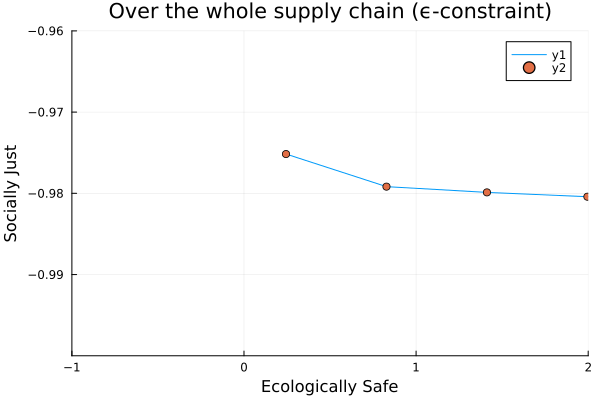

In [32]:
x_axis = ls
y_axis = res

plot(x_axis, y_axis, xlims=(-1, 2), ylims=(-1,-0.96))
plot!(x_axis, y_axis, seriestype=:scatter)

title!("Over the whole supply chain (ϵ-constraint)")
xlabel!("Ecologically Safe")
ylabel!("Socially Just")